In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
import numpy as np
from tqdm import tqdm
from pathlib import Path
import openslide
import pandas as pd
import pickle

In [4]:
from fastai.callbacks.csv_logger import CSVLogger

In [5]:
from object_detection_fastai.helper.object_detection_helper import *
from object_detection_fastai.helper.wsi_loader import *
from object_detection_fastai.loss.RetinaNetFocalLoss import RetinaNetFocalLoss
from object_detection_fastai.models.RetinaNet import RetinaNet
from object_detection_fastai.callbacks.callbacks import BBLossMetrics, BBMetrics, PascalVOCMetric, PascalVOCMetricByDistance

In [6]:
slides_val = list(set([#'BAL Promyk Spray 4.svs',
                        'BAL AIA Blickfang Luft.svs'
                      ]))

slides_train = list(set(['BAL 1 Spray 2.svs', 
                         'BAL Booker Spray 3.svs',
                         'BAL Bubi Spray 1.svs', 
                         'BAL cent blue Luft 2.svs']))

labels = ['Mastzellen', "Makrophagen", "Neutrophile", "Eosinophile", "Lymohozyten"]

In [7]:
experiment_name = "Asthma-L0-Screening-V1"

In [8]:
annotations_path = Path("../Statistics/Asthma_Annotations.pkl")
annotations = pd.read_pickle(annotations_path)

annotations = annotations[annotations["class"].isin(labels)]
annotations_train = annotations[annotations["image_name"].isin(slides_train)]
annotations_val = annotations[annotations["image_name"].isin(slides_val)]
annotations_train.head()

id  image_id         image_name  image_set        class  \
0  172441       221  BAL 1 Spray 2.svs         14  Makrophagen   
1  172442       221  BAL 1 Spray 2.svs         14  Makrophagen   
2  172443       221  BAL 1 Spray 2.svs         14  Makrophagen   
3  172444       221  BAL 1 Spray 2.svs         14  Makrophagen   
4  172446       221  BAL 1 Spray 2.svs         14  Makrophagen   

                                              vector  \
0  {'x1': 13612, 'x2': 13666, 'y1': 12371, 'y2': ...   
1  {'x1': 13562, 'x2': 13618, 'y1': 12437, 'y2': ...   
2  {'x1': 13482, 'x2': 13546, 'y1': 12458, 'y2': ...   
3  {'x1': 13471, 'x2': 13533, 'y1': 12281, 'y2': ...   
4  {'x1': 13591, 'x2': 13673, 'y1': 12204, 'y2': ...   

                      unique_identifier  user_id  deleted last_editor  
0  a268b46f-e13f-480e-b96d-c7900790ad5f       10    False        None  
1  e8d67efd-0baf-4f78-ad73-b8f77422b826       10    False        None  
2  55aa3d51-7f30-43a0-83ef-d9acc74d9a21       10    False        None  
3  8f259e8f-119b-44de-8a90-2c53e7ee0e60       10    False        None  
4  052b3f5a-f6f6-4b0d-a134-9f4797601dc4       10    False        None

In [9]:
annotations["width"] = [vector["x2"] - vector["x1"] for vector in annotations["vector"]]
annotations["height"] = [vector["y2"] - vector["y1"] for vector in annotations["vector"]]
annotations["scale"] = annotations["width"] / annotations["height"]

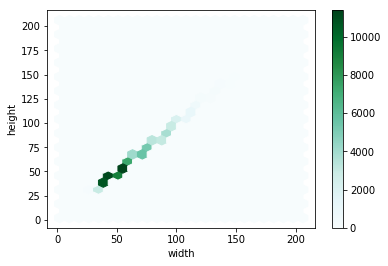

In [10]:
annotations.plot.hexbin(x='width', y='height', gridsize=25) #C='scale', 

In [11]:
slides_path = Path("../Slides")
files = {slide.name: slide for slide in slides_path.rglob("*.svs") if slide.name in slides_train + slides_val}
files

{'BAL 1 Spray 2.svs': PosixPath('../Slides/BAL 1 Spray 2.svs'),
 'BAL AIA Blickfang Luft.svs': PosixPath('../Slides/BAL AIA Blickfang Luft.svs'),
 'BAL Booker Spray 3.svs': PosixPath('../Slides/BAL Booker Spray 3.svs'),
 'BAL Bubi Spray 1.svs': PosixPath('../Slides/BAL Bubi Spray 1.svs'),
 'BAL cent blue Luft 2.svs': PosixPath('../Slides/BAL cent blue Luft 2.svs')}

In [12]:
with open('../Statistics/Screening.pickle', 'rb') as handle:
    screening_modes = pickle.load(handle)

In [13]:
def filterAnnotations(image_name, xmin, ymin, screening_modes, patch_x:int = 1024, patch_y:int = 1024):
    
    screening = screening_modes[image_name]
    tiles = screening["screening_tiles"]  
    
    xmin, ymin = max(1, int(xmin - patch_x / 2)), max(1, int(ymin - patch_y / 2))
    
    x_step = int(np.ceil(xmin / screening["x_resolution"]))
    y_step = int(np.ceil(ymin / screening["y_resolution"]))
    
    return tiles[str((y_step * screening["x_steps"]) + x_step)]['Screened']

In [14]:
annotations_train["border"] = annotations_train.apply(lambda x: filterAnnotations(x["image_name"], x["vector"]["x1"], x["vector"]["y1"], screening_modes), axis=1)
annotations_val["border"] = annotations_val.apply(lambda x: filterAnnotations(x["image_name"], x["vector"]["x1"], x["vector"]["y1"], screening_modes), axis=1)
annotations_val.head()

/home/c.marzahl@de.eu.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/c.marzahl@de.eu.local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


id  image_id                  image_name  image_set        class  \
46022  100794       222  BAL AIA Blickfang Luft.svs         14  Makrophagen   
46023  100795       222  BAL AIA Blickfang Luft.svs         14  Makrophagen   
46024  100796       222  BAL AIA Blickfang Luft.svs         14  Makrophagen   
46025  100798       222  BAL AIA Blickfang Luft.svs         14  Makrophagen   
46026  100799       222  BAL AIA Blickfang Luft.svs         14  Makrophagen   

                                                  vector  \
46022  {'x1': 14253, 'x2': 14335, 'y1': 1973, 'y2': 2...   
46023  {'x1': 10463, 'x2': 10567, 'y1': 3139, 'y2': 3...   
46024  {'x1': 10562, 'x2': 10656, 'y1': 3058, 'y2': 3...   
46025  {'x1': 11028, 'x2': 11116, 'y1': 3181, 'y2': 3...   
46026  {'x1': 11312, 'x2': 11410, 'y1': 3142, 'y2': 3...   

                          unique_identifier  user_id  deleted last_editor  \
46022  34e5b9dc-384b-4340-8860-f7f9c0f95b8f       10    False        None   
46023  bf998488-a896-4543-8d54-4542da0592e8       10    False        None   
46024  58bd7590-ff84-43c8-a065-b2186092bff2       10    False        None   
46025  d26e8e97-db24-4a80-b22c-b5009e68faac       10    False        None   
46026  dffb2f9a-1da6-4e54-9e54-7e2a2d0623ca       10    False        None   

       border  
46022    True  
46023    True  
46024    True  
46025    True  
46026    True

In [15]:
class SlideContainerWithScreening(SlideContainer):

    def get_new_train_coordinates(self):
        # use passed sampling method
        if callable(self.sample_func):
            return self.sample_func(self.y, **{"classes": self.classes, "size": self.shape,
                                               "level_dimensions": self.slide.level_dimensions,
                                               "level": self.level})

        # use default sampling method
        width, height = self.slide.level_dimensions[self.level]
        if len(self.y[0]) == 0:
            return randint(0, width - self.shape[0]), randint(0, height - self.shape[1])
        else:
            # use default sampling method
            class_id = np.random.choice( self.classes, 1)[0]
            ids = (np.array(self.y[1]) == class_id) & (np.array(self.y[2]) == True)
            #  if you can´t fond any ignore screened area
            if np.count_nonzero(ids) == 0:
                ids = (np.array(self.y[1]) == class_id)
            xmin, ymin, _, _ = np.array( self.y[0])[ids][randint(0, np.count_nonzero(ids) - 1)]

            xmin, ymin = max(1, int(xmin - self.shape[0] / 2)), max(1, int(ymin - self.shape[1] / 2))
            xmin, ymin = min(xmin, width - self.shape[0]), min(ymin, height - self.shape[1])

            return xmin, ymin

In [16]:
size = 1024 
level = 0
bs = 16
train_images = 500
val_images = 500

In [17]:
train_files = []
val_files = []

In [18]:
for image_name in annotations_train["image_name"].unique():
    
    annotations = annotations_train[annotations_train["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    borders = list(annotations["border"])
    
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)
            borders.append(True)

    train_files.append(SlideContainerWithScreening(slide_path, y=[bboxes, labels, borders],  level=level, width=size, height=size))
    
for image_name in annotations_val["image_name"].unique():
    
    annotations = annotations_val[annotations_val["image_name"] == image_name]
    annotations = annotations[annotations["deleted"] == False]
    
    slide_path = files[image_name]
    labels =  list(annotations["class"])
    borders = list(annotations["border"])
    
    bboxes = [[vector["x1"], vector["y1"], vector["x2"], vector["y2"]] for vector in annotations["vector"]]
    
    for label in labels:
        if label not in set(labels):
            bboxes.append([0,0,0,0])
            labels.append(label)
            borders.append(True)

    val_files.append(SlideContainerWithScreening(slide_path, y=[bboxes, labels, borders],  level=level, width=size, height=size))

train_files = list(np.random.choice(train_files, train_images))
valid_files = list(np.random.choice(val_files, val_images))

In [19]:
tfms = get_transforms(do_flip=True,
                      flip_vert=True,
                      #max_rotate=90,
                      #max_lighting=0.0,
                      #max_zoom=1.,
                      #max_warp=0.0,
                      #p_affine=0.5,
                      #p_lighting=0.0,
                      #xtra_tfms=xtra_tfms,
                     )

In [20]:
def get_y_func(x):
    return x.y

In [21]:
train =  ObjectItemListSlide(train_files, path=slides_path)
valid = ObjectItemListSlide(valid_files, path=slides_path)
item_list = ItemLists(slides_path, train, valid)
lls = item_list.label_from_func(get_y_func, label_cls=SlideObjectCategoryList) #
lls = lls.transform(tfms, tfm_y=True, size=size)
data = lls.databunch(bs=bs, collate_fn=bb_pad_collate, num_workers=0).normalize()

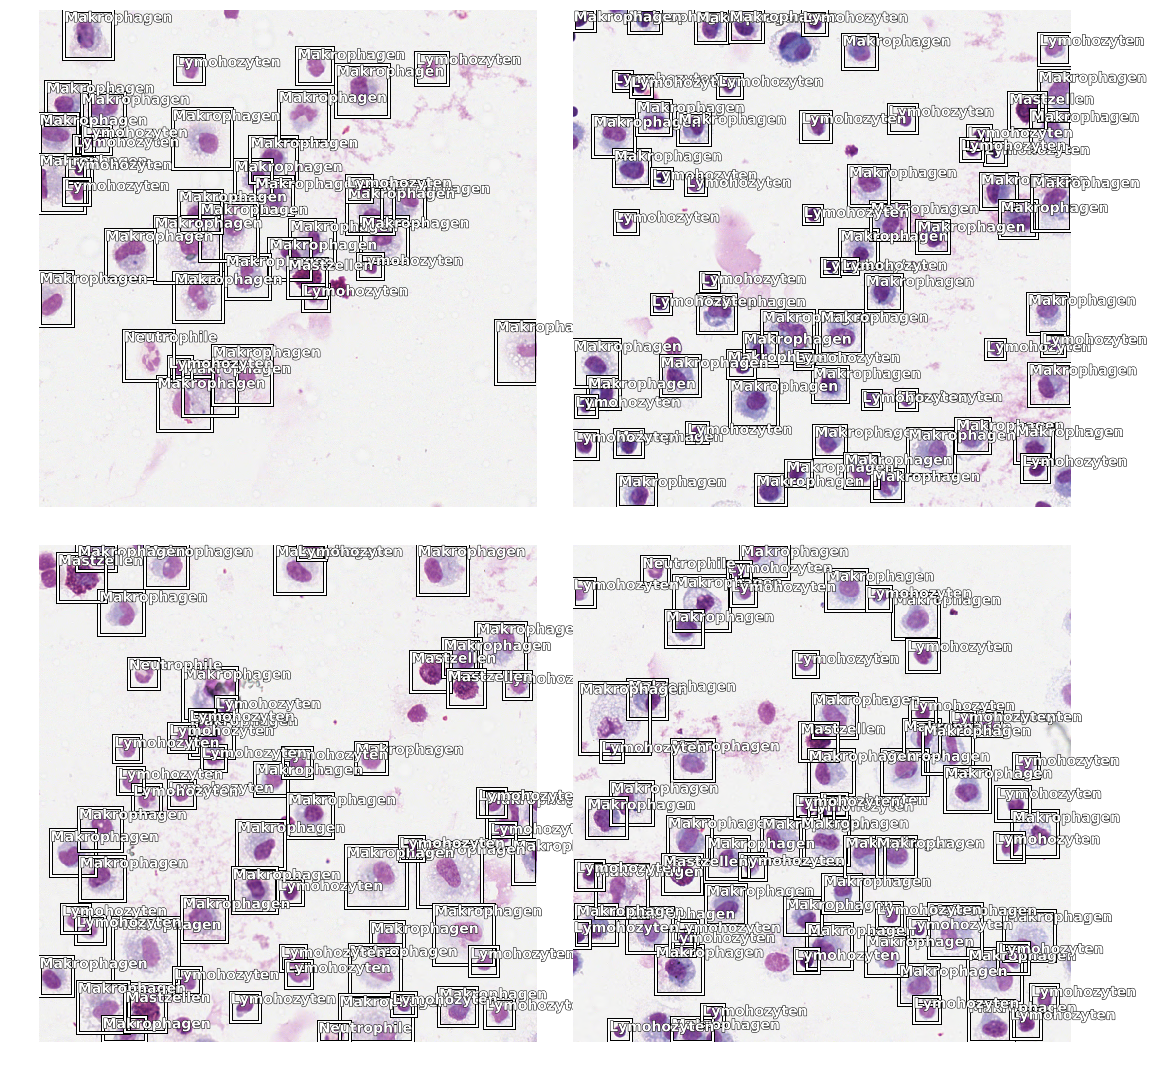

In [22]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(15,15))

In [23]:
scales = [.8, .9, 1, 1.1]
anchors = create_anchors(sizes=[(64, 64), (32,32)], ratios=[1], scales=scales)

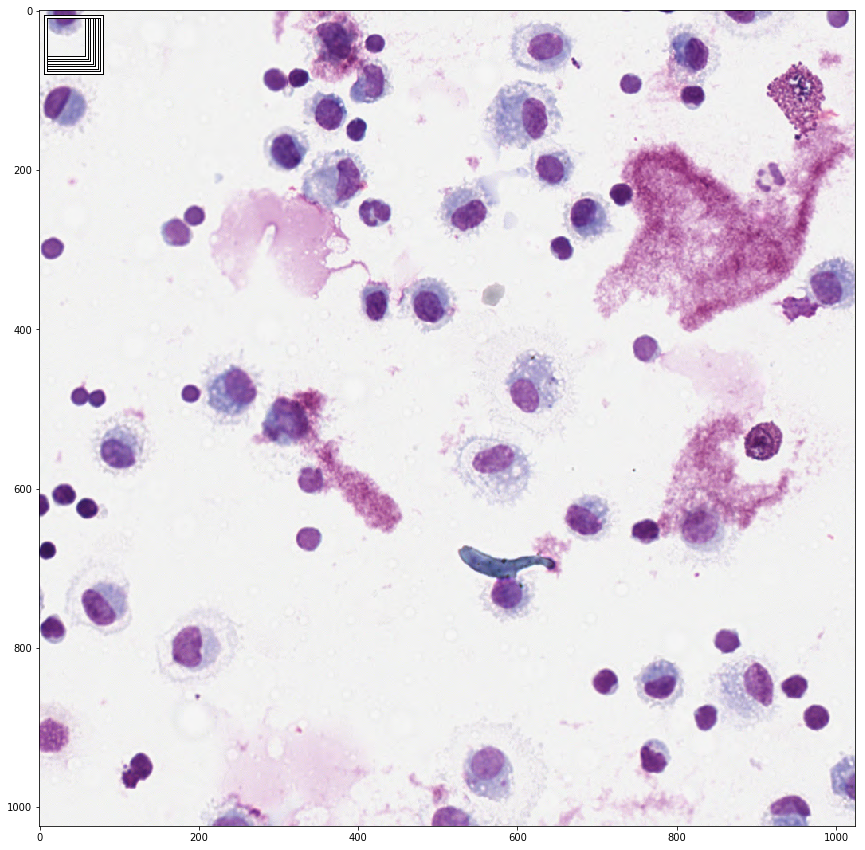

In [24]:
fig,ax = plt.subplots(figsize=(15,15))
ax.imshow(image2np(data.valid_ds[0][0].data))

for i, bbox in enumerate(anchors[:len(scales)]):
    bb = bbox.numpy()
    x = (bb[0] + 1) * size / 2 
    y = (bb[1] + 1) * size / 2 
    w = bb[2] * size / 2
    h = bb[3] * size / 2
    
    rect = [x,y,w,h]
    draw_rect(ax,rect)

In [25]:
crit = RetinaNetFocalLoss(anchors)

encoder = create_body(models.resnet18, True, -2)
model = RetinaNet(encoder, n_classes=data.train_ds.c, n_anchors=len(scales), sizes=[64, 32], chs=128, final_bias=-4., n_conv=2)

In [26]:
data.train_ds.y.classes[1:]

['Eosinophile', 'Lymohozyten', 'Makrophagen', 'Mastzellen', 'Neutrophile']

In [27]:
voc = PascalVOCMetricByDistance(anchors, size, [str(i) for i in data.train_ds.y.classes[1:]], radius=40)
learn = Learner(data, model, loss_func=crit, callback_fns=[BBMetrics], #BBMetrics, ShowGraph
                metrics=[voc])

In [28]:
learn.split([model.encoder[6], model.c5top5])
learn.freeze_to(-2)

In [29]:
learn.fit_one_cycle(3, 1e-3)

In [30]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

In [31]:
learn.fit_one_cycle(10, 1e-3)

In [32]:
learn.fit_one_cycle(10, 1e-3)

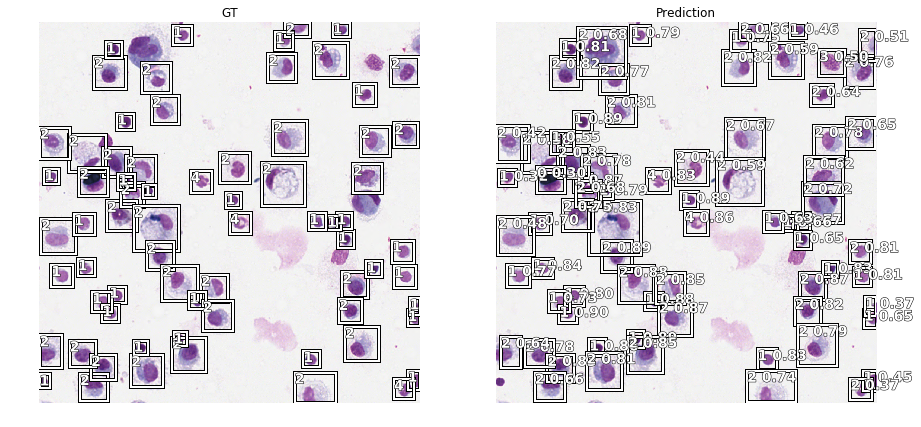

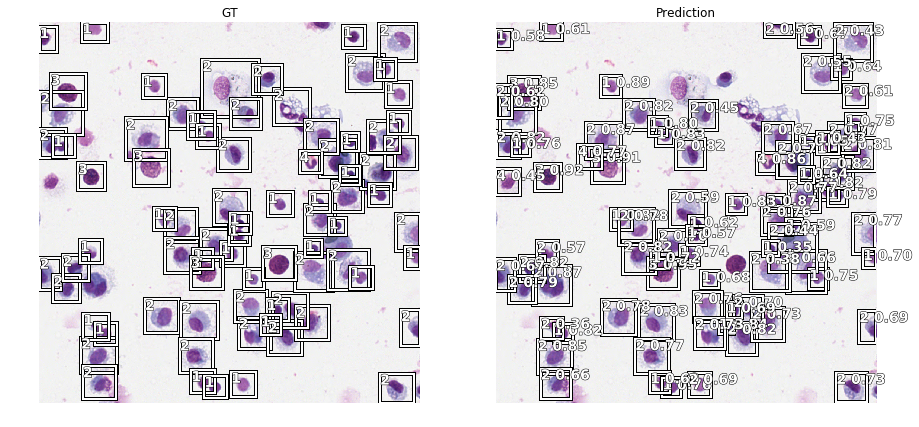

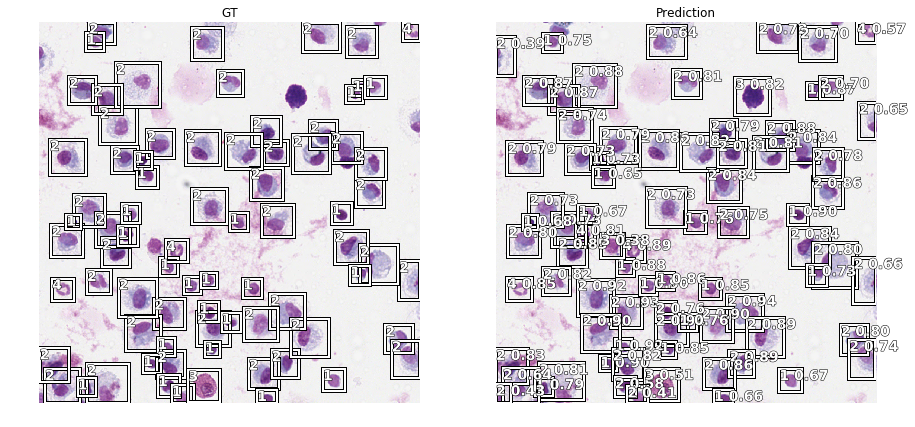

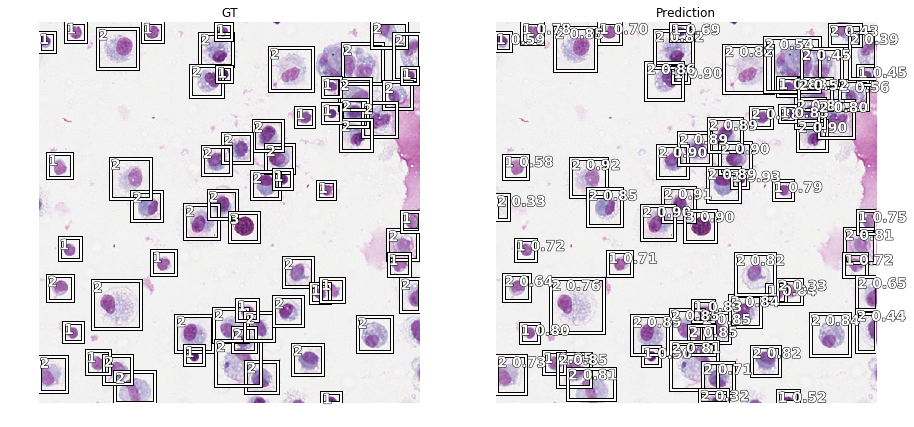

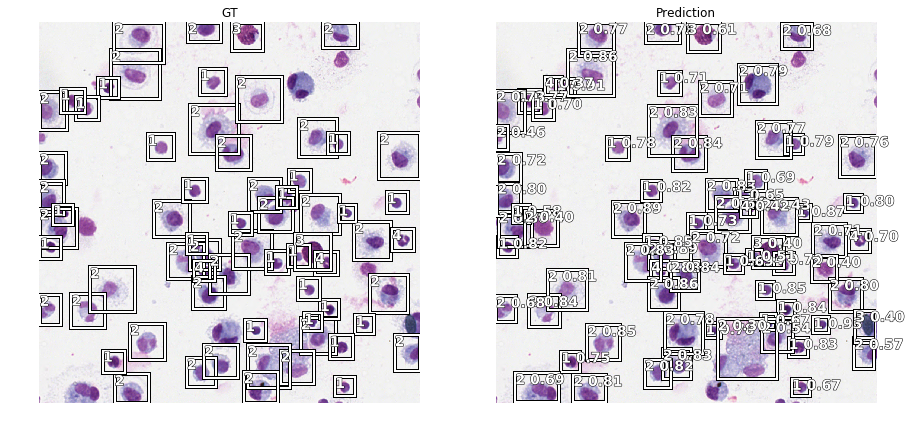

In [33]:
slide_object_result(learn, anchors, detect_thresh=0.3, nms_thresh=0.2)

In [34]:
data.c

6

In [35]:
import pickle

stats = {"anchors": anchors,
         "mean": to_np(data.stats[0]),
         "std": to_np(data.stats[1]),
         "size": size,
         "n_classes": data.c,
         "n_anchors": len(scales),
         "sizes": [64, 32],
         "chs": 128,
         "encoder": "RN-18",
         "n_conv": 2,
         "level": 0,
         "model": get_model(learn.model).state_dict()
        }

torch.save(stats, "{}.p".format(experiment_name))

In [36]:
data.classes 

['background',
 'Eosinophile',
 'Lymohozyten',
 'Makrophagen',
 'Mastzellen',
 'Neutrophile']

In [37]:
learn.fit_one_cycle(10, 1e-4)

In [38]:
learn.fit_one_cycle(10, 1e-4)

In [39]:
learn.fit_one_cycle(10, 1e-5)